In [28]:
import imageio
import cv2
import subprocess
import librosa
import librosa.display
import soundfile as sf
import os
import torch
from torchvision import transforms
from inference.Inferencer import Inferencer
from models.PasticheModel import PasticheModel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from PIL import Image
from pathlib import Path
import tqdm.notebook as tq
import h5py

In [2]:
# setup style transfer model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_styles = 16
image_size = 512
model_save_dir = "model/pastichemodel-FINAL.pth"
model_save_dir = "model/pastichemodel_style1_2-FINAL.pth"
pastichemodel = PasticheModel(num_styles)
inference = Inferencer(pastichemodel,device,image_size)
inference.load_model_weights(model_save_dir)   

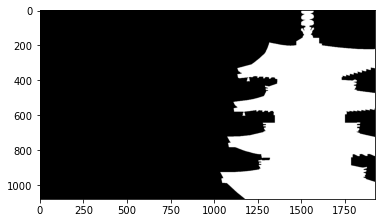

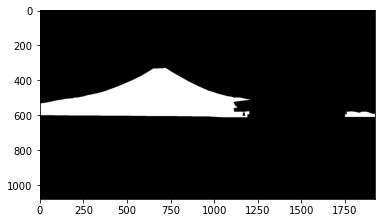

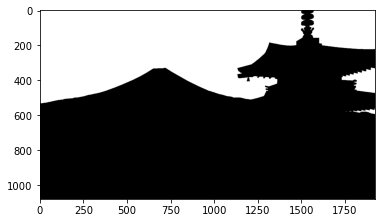

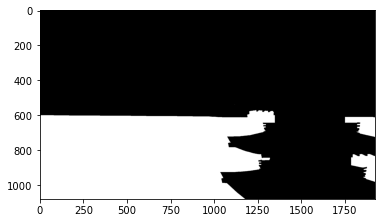

In [3]:
# image paths
im_fold = r'C:\deep_style_beats\images\pagoda\\'
ref_im_path = im_fold+'pagoda.jpg'
mask_paths = [im_fold+'pagoda.png',
              im_fold+'mountain.png',
              im_fold+'sky.png',
              im_fold+'ground.png']


#load images and setup masks (masks setup is very ugly but oh well)
ref_im = Image.open(ref_im_path).convert('RGB')
#test_im = get_transformation(ref_im, 0.3, strength=0.6)
masks = []
for mp in mask_paths:
    masks.append(cv2.resize(np.where(imageio.imread(mp)[:,:,:3]>0,1,0), dsize=(1920, 1080), interpolation=cv2.INTER_NEAREST))
#masks.append(np.where(masks[0]==1, 1,0))

# for m in masks[1:-1]:
#     masks[-1] += m
# masks[-1] = np.where(masks[-1]==0, 1, 0)
for m in masks:
    plt.imshow(m*255, cmap=plt.cm.gray)
    plt.show()

In [4]:
#prep images
def prep_transformations(im, ims_per_style, strength=1):
    transformed_images = []
    tmp_path = r'tmp_images\\'
    shape = np.array(ref_im).shape
    ref = np.array(ref_im)
    ref = cv2.resize(ref, dsize=(1920, 1080), interpolation=cv2.INTER_NEAREST)
    for i in tq.trange(num_styles):
        for j in tq.trange(ims_per_style, leave=False, position=0):
            fname = 't_style_%d_blend_%d_str_%d.png'%(i, j, strength*100)
            style_2 = i + 1 if i < 15 else 0
            tmp = inference.eval_image(im, i, style_2, 1-(j/ims_per_style))
            tmp = np.array(tmp)
            tmp = cv2.resize(tmp, dsize=(1920, 1080), interpolation=cv2.INTER_NEAREST)
            transformed_images.append(np.array(strength * tmp + (1-strength) * ref, dtype='uint8'))
            #tmp = np.array(strength * tmp + (1-strength) * ref, dtype='uint8')
            #imageio.imsave(tmp_path+fname, tmp)
                           
    return transformed_images

In [74]:
#prep images
def prep_transformations_h5(im, ims_per_style, strength=[1,0.5]):
    f = h5py.File(r'tmp_images\\ims.h5', 'w')
    arr = f.create_dataset('ims', (len(strength), ims_per_style*num_styles, 1080, 1920, 3), chunks=True)
    ref = np.array(ref_im)
    ref = cv2.resize(ref, dsize=(1920, 1080), interpolation=cv2.INTER_NEAREST)
    for k, s in enumerate(tq.tqdm(strength)):
        for i in tq.trange(num_styles):
            for j in tq.trange(ims_per_style, leave=False, position=0):
                style_2 = i + 1 if i < 15 else 0
                tmp = inference.eval_image(im, i, style_2, 1-(j/ims_per_style))
                tmp = np.array(tmp)
                tmp = cv2.resize(tmp, dsize=(1920, 1080), interpolation=cv2.INTER_NEAREST)
                tmp = np.array(s * tmp + (1-s) * ref, dtype='uint8')
                #print(k, i, j, i*ims_per_style+j)
                arr[k][i*ims_per_style+j] = tmp
                #tmp = np.array(strength * tmp + (1-strength) * ref, dtype='uint8')
                #imageio.imsave(tmp_path+fname, tmp)
                           
    return f, arr

In [79]:
%%time
ims_per_style = 20
# t_ims_str_high = prep_transformations(ref_im, ims_per_style)
# t_ims_str_low = prep_transformations(ref_im, ims_per_style, strength=0.5)
# t_ims = [t_ims_str_high, t_ims_str_low]
f, arr = prep_transformations_h5(ref_im, ims_per_style)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Wall time: 32min 56s


In [78]:
f.close()

In [8]:
def get_transform_from_prepped_multi(t_ims, pos, mask, str_index, ims_per_style):
    if type(str_index) is not list:
        str_index = [str_index for s in range(len(pos))]
    pos = [p - int(p) for p in pos]
    t_index = int(round(pos[0]*ims_per_style*num_styles))
    t_index = 0 if t_index == len(t_ims[0]) else t_index
    out = mask[0] * t_ims[str_index[0]][t_index]
    for i, p in enumerate(pos[1:]):
        t_index = int(round(p*ims_per_style*num_styles))
        t_index = 0 if t_index == len(t_ims[0]) else t_index
        try:
            out += mask[i+1] * t_ims[str_index[i+1]][t_index]
        except IndexError:
            print(i, len(mask), len(str_index), t_index, len(t_ims[0]))
    return out

In [9]:
audio_dir = r'C:\deep_style_beats\audio\mona wonderlick\\' 
tracks = ["Coastin'.mp3",
          'Afternoon Tea.mp3',
          'Kimochii.mp3',
          'Lovely Things.mp3',
          'Lolo Popo.mp3',
          'Free Range.mp3',                    
          'Himalayas.mp3',
          'Poptarts.mp3',
          'Creamy Soda.mp3',
          'Suede.mp3',
          'Wakanda.mp3',
          'Alone Together.mp3',
          'Bloom.mp3',
          'Golden.mp3',
          'Laundrette.mp3',
          'New Day.mp3',
          'Saviour.mp3',
          'Turning Times.mp3',
          'Undone.mp3',
          'Nina.mp3',
         ]

In [29]:
pos1_floor = 0
pos2_floor = 0.5
pos3 = 0.25
pos4 = 0.75

for ii, t in enumerate(tracks[14:15]):
    z, sr = librosa.load(audio_dir+t, offset = 20.0, duration = 20)
    out_audio_path = r'C:\deep_style_beats\audio\tmp' + str.zfill(str(ii),2) + '.wav'
    out_video_path = r'C:\deep_style_beats\video\tmp' + str.zfill(str(ii),2) + '.avi'
    sf.write(out_audio_path, z, sr)
    _, z = librosa.effects.hpss(z)
    hop_length = 735
    Nfft = 2048
    n_mels = 5
    z = librosa.feature.melspectrogram(z, sr=sr, n_fft=Nfft, hop_length=hop_length, n_mels=n_mels)
    z= librosa.power_to_db(z)
    z = (z - z.min()) / (z.max() - z.min())
    writer = imageio.get_writer(out_video_path, fps=30, mode='I', macro_block_size=1)
    pos3 = 0.25
    pos4 = 0.75
    for i, (sbass, bass, med, treb, utreb) in enumerate(tq.tqdm(z.T, desc=t)):
#         if i%30 == 0:
#             print(i/30)
        pos1_floor += 1/1000
        pos2_floor += 1/1000
        pos1 = pos1_floor + sbass/16
        pos2 = pos2_floor + treb/16
        pos3 += med/400
        pos4 += bass/400
        pos = [pos1, pos2, pos3, pos4]
        str_index = [0,0,1,1]
        im = get_transform_from_prepped_multi(t_ims, pos, masks, str_index, ims_per_style)
        writer.append_data(np.array(im, dtype='uint8'))
    writer.close()
    out_path = r'C:\deep_style_beats\video\pagoda_test_20_perc.avi'
    command = 'ffmpeg -i ' + out_video_path + ' -i ' + out_audio_path + ' -c copy -map 0:v:0 -map 1:a:0 ' + out_path
    print(command)
    subprocess.call(command, shell=True)

Laundrette.mp3:   0%|          | 0/601 [00:00<?, ?it/s]

ffmpeg -i C:\deep_style_beats\video\tmp00.avi -i C:\deep_style_beats\audio\tmp00.wav -c copy -map 0:v:0 -map 1:a:0 C:\deep_style_beats\video\pagoda_test_20_perc.avi


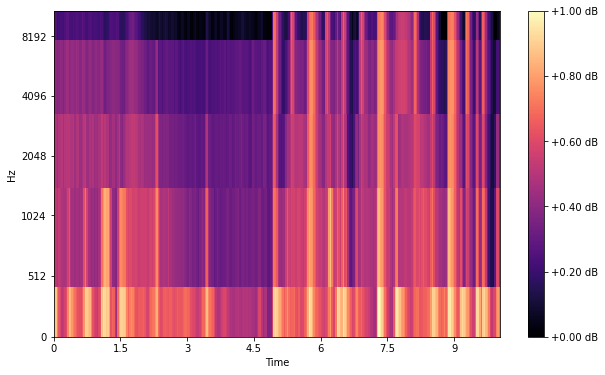

In [13]:
def mel_grams():
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(z,
                             x_axis="time",
                             y_axis="mel",
                             sr=sr,
                            hop_length=hop_length)
    plt.colorbar(format="%+2.2f dB")
    plt.show()
mel_grams()

In [24]:
def get_multi_transformations(im, pos, masks, strength=1):
    if type(strength) is not list:
        strength = [strength for s in range(len(pos))]
        #cv2.resize(get_transformation(im, pos[0], strength=strength[0]), dsize=(1920, 1080), interpolation=cv2.INTER_NEAREST)
    out = cv2.resize(get_transformation(im, pos[0], strength=strength[0]), dsize=(1920, 1080), interpolation=cv2.INTER_NEAREST) * masks[0]
    for i, p in enumerate(pos[1:]):
        out += cv2.resize(get_transformation(im, pos[i+1], strength=strength[i+1]), dsize=(1920, 1080), interpolation=cv2.INTER_NEAREST) * masks[i+1]
    return out

In [25]:
# function to transform image
def get_transformation(im, pos, strength=1):
    #im = reference frame
    #pos is float from 0 to 1 that interps between the images
    #strength float 0 to 1 that sets blending between ref and transformed image. strength 1 is 100% transformed
    pos = pos - int(pos)
    style_1 = int(pos*16)
    style_2 = style_1 + 1 if style_1 < 15 else 0
    blend = pos*16 - style_1
    out = np.array(inference.eval_image(im, style_1, style_2, 1-blend))
    shape = np.array(ref_im).shape
    styled = cv2.resize(out, dsize=(shape[1], shape[0]), interpolation=cv2.INTER_NEAREST)
    ref = np.array(ref_im)
    out = np.array(strength * styled + (1-strength) * ref, dtype='uint8')
    return out

In [27]:
pos1_floor = 0
pos2_floor = 0.5
pos3 = 0.25
pos4 = 0.75
strength = [1,1,0.5,0.5]
for ii, t in enumerate(tracks[14:15]):
    z, sr = librosa.load(audio_dir+t, offset = 20.0, duration = 20)
    out_audio_path = r'C:\deep_style_beats\audio\tmp' + str.zfill(str(ii),2) + '.wav'
    out_video_path = r'C:\deep_style_beats\video\tmp' + str.zfill(str(ii),2) + '.avi'
    sf.write(out_audio_path, z, sr)
    _, z = librosa.effects.hpss(z)
    hop_length = 735
    Nfft = 2048
    n_mels = 5
    z = librosa.feature.melspectrogram(z, sr=sr, n_fft=Nfft, hop_length=hop_length, n_mels=n_mels)
    z= librosa.power_to_db(z)
    z = (z - z.min()) / (z.max() - z.min())
    writer = imageio.get_writer(out_video_path, fps=30, mode='I', macro_block_size=1)
    pos3 = 0.25
    pos4 = 0.75
    for i, (sbass, bass, med, treb, utreb) in enumerate(tq.tqdm(z.T, desc=t)):
#         if i%30 == 0:
#             print(i/30)
        pos1_floor += 1/1000
        pos2_floor += 1/1000
        pos1 = pos1_floor + sbass/16
        pos2 = pos2_floor + treb/16
        pos3 += med/400
        pos4 += bass/400
        pos = [pos1, pos2, pos3, pos4]
        str_index = [0,1,1,1]
        im = get_multi_transformations(ref_im, pos, masks, strength = [1,1,0.5,0.5])
        writer.append_data(np.array(im, dtype='uint8'))
    writer.close()
    out_path = r'C:\deep_style_beats\video\pagoda_test_full_perc.avi'
    command = 'ffmpeg -i ' + out_video_path + ' -i ' + out_audio_path + ' -c copy -map 0:v:0 -map 1:a:0 ' + out_path
    print(command)
    subprocess.call(command, shell=True)

Laundrette.mp3:   0%|          | 0/601 [00:00<?, ?it/s]

ffmpeg -i C:\deep_style_beats\video\tmp00.avi -i C:\deep_style_beats\audio\tmp00.wav -c copy -map 0:v:0 -map 1:a:0 C:\deep_style_beats\video\pagoda_test_full_perc.avi


In [1]:
for i in range(20):
    print(i % 3)

0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1


In [2]:
import pandas as pd

In [3]:
def parse_track_list(list_paths, mode='chillhop'):
    #list_paths should be a text file with track lists
    tl = []
    for lp in list_paths:
        with open(lp, 'r') as f:
            for l in f:
                if l.strip() == '':
                    continue
                t = {}
                t['artist'], res = l.split(' - ')
                t['title'] = res.split(' https:')[0]
                t['link'] = res.split(t['title']+' ')[1].rstrip()
                t['fpath'] = r'C:\deep_style_beats\audio\chillhop\\' + t['title'] + '.mp3'
                tl.append(t)
    return pd.DataFrame.from_dict(tl)

In [4]:
list_paths = [r'C:\deep_style_beats\audio\chillhop\chillhop essentials spring 2021.txt',
              r'C:\deep_style_beats\audio\chillhop\chillhop essentials winter 2020.txt']
df_both = parse_track_list(list_paths)

df1 = df_both.sample(frac=0.5, random_state=1)
df2 = df_both.drop(df1.index).sample(frac=1, random_state=1)

In [11]:
for ii, t in df1.reset_index().iterrows():
    # get ref_ims
    print(ii % 3, int(ii/3) % 2)

0 0
1 0
2 0
0 1
1 1
2 1
0 0
1 0
2 0
0 1
1 1
2 1
0 0
1 0
2 0
0 1
1 1
2 1
0 0
1 0
2 0
0 1
1 1
2 1
0 0


In [12]:
import ipywidgets as widgets

In [14]:
import tqdm.notebook as tq

In [16]:
from IPython.core.display import HTML, display
def rm_out_padding(): display(HTML("<style>div.output_subarea { padding:unset;}</style>"))
rm_out_padding()